# Modeling an epidemic.
## SIR model
The SIR model is a couple of differential equations that work together. That system is

\begin{equation}
\Large\begin{array}{c}
\frac{dS}{dt}=-\beta SI \\
\frac{dI}{dt}=\beta SI-vI \\
\frac{dR}{dt}=vI
\end{array}
\end{equation}

In this equation, $S$ are the susceptible individuals, $I$ are the infected individuals and $R$ are the Recovered individuals. $\beta$ are the rate of individuals per period that become infected and $v$ are the rate of individuals per period that become recovered. 

We can look that $\beta$ is multiplied by $S$ and $I$ because this rate depends of both individuals, while $v$ only is multiplied by $I$. In this model, the total poblation is conserved (there are no births or deaths).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

You can discretized the equations with Euler method. That say that:

\begin{equation}
\frac{dx}{dt}\approx\frac{x_{i+1}-x_i}{\Delta t}
\end{equation}

In this case, the system of equations are:

\begin{equation}
\Large\begin{array}{c}
S_{i+1}=S_i+\Delta t\left(\frac{dS}{dt}\right) \\
I_{i+1}=I_i+\Delta t\left(\frac{dI}{dt}\right) \\
R_{i+1}=R_i+\Delta t\left(\frac{dR}{dt}\right)
\end{array}
\end{equation}

Using the system of equations from the SIR model, we had

\begin{equation}
\Large\begin{array}{c}
S_{i+1}=S_i-\Delta t\beta S_iI_i \\
I_{i+1}=I_i+\Delta t(\beta S_iI_i-vI_i) \\
R_{i+1}=R_i+\Delta tvI_i
\end{array}
\end{equation}

We can rewrite the system of equations as:

\begin{equation}
\Large\begin{array}{c}
S_{i+1}=S_i(1-\Delta t\beta I_i) \\
I_{i+1}=I_i(1+\Delta t(\beta S_i-v)) \\
R_{i+1}=R_i+\Delta tvI_i
\end{array}
\end{equation}

In [2]:
@njit()
def sir(N,dt,beta,v,S0,I0,R0):
    S,I,R=IC(N,S0,I0,R0)
    for i in range(0,N-1):
        S[i+1]=S[i]*(1-dt*beta*I[i])
        I[i+1]=I[i]*(1+dt*(beta*S[i]-v))
        R[i+1]=R[i]+dt*v*I[i]
    return S,I,R

@njit()
def IC(N,S0,I0,R0):
    S=np.zeros(N)
    I=np.zeros(N)
    R=np.zeros(N)
    #Put the initial conditon for every system
    S[0]=S0
    I[0]=I0
    R[0]=R0
    return S,I,R

We can observe how it works the system. We know that $N=S+I+R$. 

To observe it, we can do

* $N=10,000$
* $t_f=100$ days
* $I_0=10$
* $R_0=5$
* $S_0=N-I_0-R_0$
* $v=0.05$
* $\beta=0.00005$

In [3]:
#Define the variables
N=int(1e4) #total population
tf=100      #total time of simulation
I0=10
R0=5
S0=N-I0-R0
v=0.05      #recovered rate
beta=0.00005 #Infection rate

#Define the array
t=np.linspace(0,tf,N)
#Define the timestep
dt=tf/(N)

#Solve the equations
%time S,I,R=sir(N,dt,beta,v,S0,I0,R0)

CPU times: user 1.23 s, sys: 39.3 ms, total: 1.26 s
Wall time: 1.28 s


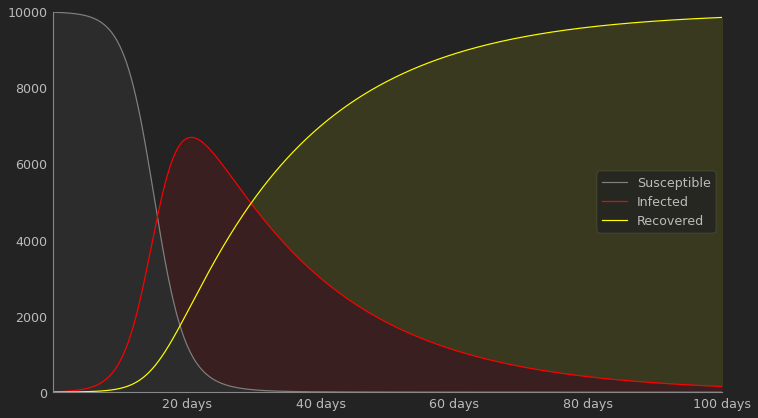

In [5]:
def graf(S,I,R,N,t):
    fig,axs=plt.subplots(figsize=(12,7))
    #Susceptible
    plt.plot(t,S, color='gray', label='Susceptible')
    plt.fill_between(t,S,0,color='gray',alpha=0.1, interpolate=True)
    #Infected
    plt.plot(t,I, color='red', label='Infected')
    plt.fill_between(t,I,S,where=(I>S),color='red',alpha=0.1, interpolate=True)
    #Recovered
    plt.plot(t,R, color='yellow', label='Recovered')
    plt.fill_between(t,I,R,where=(R>I),color='yellow',alpha=0.1, interpolate=True)
    #Another things
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.set_xticks([t[i] for i in range(int(N/5),len(t),int(N/5)-1)])
    axs.set_xticklabels(['{0:.0f} days'.format(t[i]) for i in range(int(N/5),len(t),int(N/5)-1)])
    plt.xlim(t[0],t[N-1])
    plt.ylim(0,N)
    plt.legend()
    plt.grid(False)
    plt.show()

graf(S,I,R,N,t)

## SIRS model

So, suppose that we wanted to model a desease in which individuals can have a temporary but not permanent immunity after getting infected. We can modify the system of equations to make the recovered individuals susceptible one more time. 

\begin{equation}
\Large\begin{array}{c}
\frac{dS}{dt}=-\beta SI+\gamma R \\
\frac{dI}{dt}=\beta SI-vI \\
\frac{dR}{dt}=vI-\gamma R
\end{array}
\end{equation}

We add a parameter $\gamma$ that represent the rate of conversion from recovered to susceptible per period. This model is now called SIRS model.

Using the Euler method one more time, we had

\begin{equation}
\Large\begin{array}{c}
S_{i+1}=S_i-\Delta t(\beta S_iI_i-\gamma R_i) \\
I_{i+1}=I_i+\Delta t(\beta S_iI_i-vI_i) \\
R_{i+1}=R_i+\Delta t(vI_i-\gamma R_i)
\end{array}
\end{equation}

We can rewrite the system of equations as:

\begin{equation}
\Large\begin{array}{c}
S_{i+1}=S_i(1-\Delta t\beta I_i)+\Delta t\gamma R_i \\
I_{i+1}=I_i(1+\Delta t(\beta S_i-v)) \\
R_{i+1}=R_i(1-\Delta t\gamma)+\Delta tvI_i
\end{array}
\end{equation}

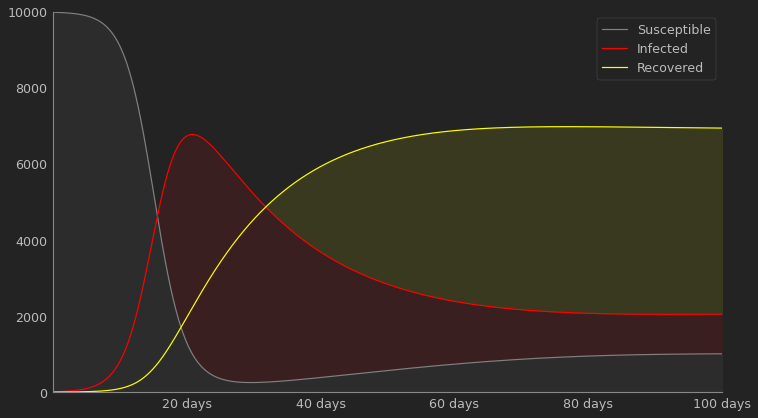

In [27]:
@njit()
def sirs(N,dt,beta,v,S0,I0,R0,gamma):
    S,I,R=IC(N,S0,I0,R0)
    for i in range(0,N-1):
        S[i+1]=S[i]*(1-dt*beta*I[i])+dt*gamma*R[i]
        I[i+1]=I[i]*(1+dt*(beta*S[i]-v))
        R[i+1]=R[i]*(1-dt*gamma)+dt*v*I[i]
    return S,I,R

gamma=0.015 #The rate of conversion from recovered to susceptible
S,I,R=sirs(N,dt,beta,v,S0,I0,R0,gamma)

graf(S,I,R,N,t)

## SIRS model with deaths and births.

Now, suppose that we want to check if during all the time of the epidemic, the people can die or new people can born. If we modify the system of equations one more time,we had:

\begin{equation}
\Large\begin{array}{c}
\frac{dS}{dt}=\Lambda(S+I+R)-\beta SI+\gamma R-\mu S \\
\frac{dI}{dt}=\beta SI-vI-\mu I \\
\frac{dR}{dt}=vI-\gamma R-\mu R
\end{array}
\end{equation}

where $\Lambda$ are the rate of births from the total population that resides in that moment (that is $S,I$ and $R$). And also, I add $\mu$ that is the rate of individuals who died.

Using the Euler method one more time, we had

\begin{equation}
\Large\begin{array}{c}
S_{i+1}=S_i-\Delta t(\beta S_iI_i+\mu S_i-\gamma R_i-\Lambda(S_i+I_i+R_i)) \\
I_{i+1}=I_i+\Delta t(\beta S_iI_i-vI_i-\mu I_i) \\
R_{i+1}=R_i+\Delta t(vI_i-\gamma R_i-\mu R_i)
\end{array}
\end{equation}

We can rewrite the system of equations as:

\begin{equation}
\Large\begin{array}{c}
S_{i+1}=S_i(1-\Delta t(\beta I_i+\mu-\Lambda))+\Delta t(\gamma-\Lambda) R_i+\Delta t\Lambda I_i \\
I_{i+1}=I_i(1+\Delta t(\beta S_i-v-\mu)) \\
R_{i+1}=R_i(1-\Delta t(\gamma+\mu))+\Delta tvI_i
\end{array}
\end{equation}

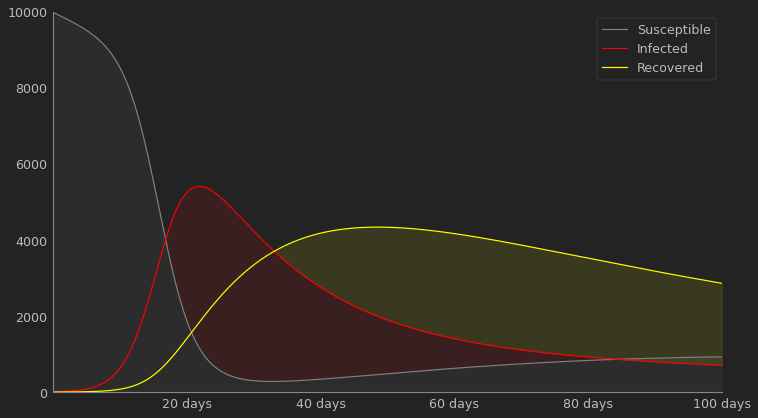

In [28]:
@njit()
def sirs_bd(N,dt,beta,v,S0,I0,R0,gamma,lam,mu):
    S,I,R=IC(N,S0,I0,R0)
    for i in range(0,N-1):
        S[i+1]=S[i]*(1-dt*(beta*I[i]+mu-lam))+dt*(gamma-lam)*R[i]+dt*lam*I[i]
        I[i+1]=I[i]*(1+dt*(beta*S[i]-v-mu))
        R[i+1]=R[i]*(1-dt*(gamma+mu))+dt*v*I[i]
    return S,I,R

lam=0.0001 #The rate of new births
mu=0.008   #The rate for death

S,I,R=sirs_bd(N,dt,beta,v,S0,I0,R0,gamma,lam,mu)    

graf(S,I,R,N,t)